In [1]:
#NLP TOOLS:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('vader_lexicon')
nltk.download("stopwords")
nltk.download("punkt")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#River and models:
import river
from river import stream
from river import metrics, utils
from river.stream import iter_pandas
from river import preprocessing
from river import optim
# Importing models that we are going to test 
from river import multiclass
from river import linear_model
from river.tree import HoeffdingTreeClassifier
from river import neighbors


#Kafka tools:
import json
from kafka import KafkaConsumer
from kafka import KafkaProducer
from json import loads

from IPython.display import display, HTML
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
topic = 'project-tweets'
counter=0

C:\Users\selma\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\selma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\selma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\selma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
consumer = KafkaConsumer(bootstrap_servers="localhost:9092", value_deserializer=lambda x: json.loads(x.decode("utf8")),)
topics_list =[topic]

consumer.subscribe(topics= topics_list)
print(consumer.bootstrap_connected()) 

True


In [3]:
def print_progress(sample_id, balanced_acc,f1, kappa):
    print(f'Samples processed: {sample_id}')
    print(balanced_acc)
    print(f1)
    print(kappa)

def evaluate(stream, model, n_wait=1000, verbose=False):
    balanced_acc = metrics.BalancedAccuracy()
    balanced_acc_roll = utils.Rolling(metrics.BalancedAccuracy(), window_size=n_wait)
    f1 = metrics.WeightedF1()
    f1_roll = utils.Rolling(metrics.WeightedF1(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        balanced_acc.update(y, y_pred)
        balanced_acc_roll.update(y, y_pred)
        f1.update(y, y_pred)
        f1_roll.update(y, y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        # Learn (train)
        model.learn_one(x, y)
        if i % n_wait == 0 and i > 0:
          if verbose:
              print_progress(i, balanced_acc, f1, kappa)
    raw_results.append([model_name, i, balanced_acc.get(), balanced_acc_roll.get(), f1.get(), f1_roll.get(), kappa.get(), kappa_rolling.get()])
    print_progress(i, balanced_acc, f1, kappa)
    return (raw_results)

In [4]:
knn = neighbors.KNNClassifier()
log_regr_one_vs_one = preprocessing.StandardScaler() | multiclass.OneVsOneClassifier(linear_model.LogisticRegression(optimizer=optim.SGD(0.1)))
Hoef_tree = HoeffdingTreeClassifier()

In [5]:
#tfidf
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
#embeddings:
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten
from tensorflow.keras.layers import Embedding
vocab_size = 300
max_length = 25

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = Sequential()
model.add(Embedding(vocab_size, 1000, input_length=max_length))
model.add(Flatten())

model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=[get_f1])

Samples processed: 9
BalancedAccuracy: 20.83%
WeightedF1: 41.30%
CohenKappa: -3.45%


Samples processed: 9
BalancedAccuracy: 16.67%
WeightedF1: 40.00%
CohenKappa: 1.64%


Samples processed: 9
BalancedAccuracy: 20.83%
WeightedF1: 43.50%
CohenKappa: 1.64%


1/1 [==============================] - 0s 107ms/step
Samples processed: 9
BalancedAccuracy: 22.22%
WeightedF1: 29.32%
CohenKappa: -27.27%
---------------------------------------------------------------


Samples processed: 19
BalancedAccuracy: 27.50%
WeightedF1: 34.15%
CohenKappa: -14.29%


Samples processed: 19
BalancedAccuracy: 31.67%
WeightedF1: 43.25%
CohenKappa: 3.51%


Samples processed: 19
BalancedAccuracy: 33.33%
WeightedF1: 33.33%
CohenKappa: 0.00%


1/1 [==============================] - 0s 26ms/step
Samples processed: 19
BalancedAccuracy: 43.33%
WeightedF1: 41.48%
CohenKappa: 8.40%
---------------------------------------------------------------


Samples processed: 29
BalancedAccuracy: 49.44%
WeightedF1: 55.40%
CohenKappa: 22.16%


Samples processed: 29
BalancedAccuracy: 50.56%
WeightedF1: 57.22%
CohenKappa: 26.97%


Samples processed: 29
BalancedAccuracy: 38.89%
WeightedF1: 46.31%
CohenKappa: 14.47%


1/1 [==============================] - 0s 23ms/step
Samples processed: 29
BalancedAccuracy: 74.44%
WeightedF1: 67.39%
CohenKappa: 47.37%
---------------------------------------------------------------


Samples processed: 39
BalancedAccuracy: 52.09%
WeightedF1: 60.92%
CohenKappa: 33.85%


Samples processed: 39
BalancedAccuracy: 49.20%
WeightedF1: 57.16%
CohenKappa: 26.49%


Samples processed: 39
BalancedAccuracy: 31.99%
WeightedF1: 36.31%
CohenKappa: -3.04%


2/2 [==============================] - 0s 3ms/step
Samples processed: 39
BalancedAccuracy: 90.20%
WeightedF1: 87.57%
CohenKappa: 79.36%
---------------------------------------------------------------


Samples processed: 49
BalancedAccuracy: 42.93%
WeightedF1: 45.39%
CohenKappa: 8.78%


Samples processed: 49
BalancedAccuracy: 37.37%
WeightedF1: 43.81%
CohenKappa: 5.41%


Samples processed: 49
BalancedAccuracy: 30.30%
WeightedF1: 32.17%
CohenKappa: -7.14%


2/2 [==============================] - 0s 2ms/step
Samples processed: 49
BalancedAccuracy: 86.87%
WeightedF1: 88.27%
CohenKappa: 80.37%
---------------------------------------------------------------


Samples processed: 59
BalancedAccuracy: 48.27%
WeightedF1: 55.56%
CohenKappa: 28.84%


Samples processed: 59
BalancedAccuracy: 47.92%
WeightedF1: 53.93%
CohenKappa: 24.19%


Samples processed: 59
BalancedAccuracy: 44.72%
WeightedF1: 50.77%
CohenKappa: 24.96%


2/2 [==============================] - 0s 9ms/step
Samples processed: 59
BalancedAccuracy: 78.67%
WeightedF1: 84.62%
CohenKappa: 75.31%
---------------------------------------------------------------


Samples processed: 69
BalancedAccuracy: 43.31%
WeightedF1: 51.84%
CohenKappa: 20.32%


Samples processed: 69
BalancedAccuracy: 42.26%
WeightedF1: 49.03%
CohenKappa: 15.41%


Samples processed: 69
BalancedAccuracy: 29.51%
WeightedF1: 32.66%
CohenKappa: -8.83%


3/3 [==============================] - 0s 2ms/step
Samples processed: 69
BalancedAccuracy: 87.81%
WeightedF1: 85.05%
CohenKappa: 75.15%
---------------------------------------------------------------


Samples processed: 79
BalancedAccuracy: 50.28%
WeightedF1: 57.09%
CohenKappa: 31.41%


Samples processed: 79
BalancedAccuracy: 36.92%
WeightedF1: 44.59%
CohenKappa: 9.60%


Samples processed: 79
BalancedAccuracy: 39.17%
WeightedF1: 46.35%
CohenKappa: 13.47%


3/3 [==============================] - 0s 2ms/step
Samples processed: 79
BalancedAccuracy: 82.76%
WeightedF1: 83.02%
CohenKappa: 72.31%
---------------------------------------------------------------


Samples processed: 89
BalancedAccuracy: 55.57%
WeightedF1: 63.19%
CohenKappa: 38.72%


Samples processed: 89
BalancedAccuracy: 50.42%
WeightedF1: 56.07%
CohenKappa: 27.27%


Samples processed: 89
BalancedAccuracy: 45.16%
WeightedF1: 51.12%
CohenKappa: 21.36%


3/3 [==============================] - 0s 3ms/step
Samples processed: 89
BalancedAccuracy: 82.92%
WeightedF1: 87.74%
CohenKappa: 79.64%
---------------------------------------------------------------


Samples processed: 99
BalancedAccuracy: 43.86%
WeightedF1: 51.19%
CohenKappa: 19.41%


Samples processed: 99
BalancedAccuracy: 39.74%
WeightedF1: 44.89%
CohenKappa: 8.03%


Samples processed: 99
BalancedAccuracy: 42.57%
WeightedF1: 52.08%
CohenKappa: 21.37%


4/4 [==============================] - 0s 2ms/step
Samples processed: 99
BalancedAccuracy: 85.95%
WeightedF1: 89.07%
CohenKappa: 81.71%
---------------------------------------------------------------


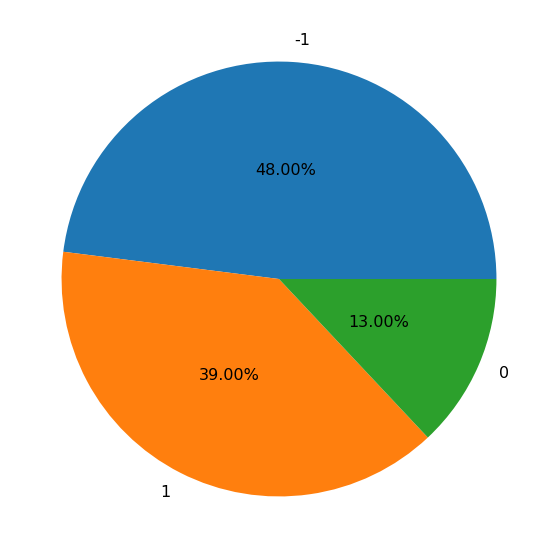

Samples processed: 109
BalancedAccuracy: 48.84%
WeightedF1: 57.03%
CohenKappa: 27.47%


Samples processed: 109
BalancedAccuracy: 46.27%
WeightedF1: 55.50%
CohenKappa: 24.74%


Samples processed: 109
BalancedAccuracy: 39.89%
WeightedF1: 50.04%
CohenKappa: 15.56%


4/4 [==============================] - 0s 0s/step
Samples processed: 109
BalancedAccuracy: 94.81%
WeightedF1: 95.49%
CohenKappa: 92.38%
---------------------------------------------------------------


Samples processed: 119
BalancedAccuracy: 45.05%
WeightedF1: 54.40%
CohenKappa: 22.88%


Samples processed: 119
BalancedAccuracy: 45.61%
WeightedF1: 54.80%
CohenKappa: 22.82%


Samples processed: 119
BalancedAccuracy: 38.45%
WeightedF1: 47.98%
CohenKappa: 12.25%


4/4 [==============================] - 0s 0s/step
Samples processed: 119
BalancedAccuracy: 92.67%
WeightedF1: 92.63%
CohenKappa: 87.48%
---------------------------------------------------------------


Samples processed: 129
BalancedAccuracy: 59.60%
WeightedF1: 64.46%
CohenKappa: 40.28%


Samples processed: 129
BalancedAccuracy: 42.37%
WeightedF1: 49.98%
CohenKappa: 16.14%


Samples processed: 129
BalancedAccuracy: 44.71%
WeightedF1: 55.25%
CohenKappa: 26.55%


5/5 [==============================] - 0s 3ms/step
Samples processed: 129
BalancedAccuracy: 92.66%
WeightedF1: 92.40%
CohenKappa: 87.27%
---------------------------------------------------------------


Samples processed: 139
BalancedAccuracy: 51.20%
WeightedF1: 57.75%
CohenKappa: 28.45%


Samples processed: 139
BalancedAccuracy: 50.93%
WeightedF1: 57.30%
CohenKappa: 26.90%


Samples processed: 139
BalancedAccuracy: 39.09%
WeightedF1: 49.05%
CohenKappa: 13.89%


5/5 [==============================] - 0s 2ms/step
Samples processed: 139
BalancedAccuracy: 95.26%
WeightedF1: 93.56%
CohenKappa: 89.25%
---------------------------------------------------------------


Samples processed: 149
BalancedAccuracy: 45.83%
WeightedF1: 54.65%
CohenKappa: 24.27%


Samples processed: 149
BalancedAccuracy: 47.21%
WeightedF1: 53.74%
CohenKappa: 22.60%


Samples processed: 149
BalancedAccuracy: 37.19%
WeightedF1: 45.50%
CohenKappa: 9.19%


5/5 [==============================] - 0s 3ms/step
Samples processed: 149
BalancedAccuracy: 91.66%
WeightedF1: 93.97%
CohenKappa: 89.96%
---------------------------------------------------------------


Samples processed: 159
BalancedAccuracy: 53.51%
WeightedF1: 59.18%
CohenKappa: 31.52%


Samples processed: 159
BalancedAccuracy: 45.00%
WeightedF1: 52.40%
CohenKappa: 19.63%


Samples processed: 159
BalancedAccuracy: 38.72%
WeightedF1: 47.91%
CohenKappa: 12.49%


5/5 [==============================] - 0s 4ms/step
Samples processed: 159
BalancedAccuracy: 89.79%
WeightedF1: 89.37%
CohenKappa: 82.40%
---------------------------------------------------------------


Samples processed: 169
BalancedAccuracy: 50.08%
WeightedF1: 59.67%
CohenKappa: 33.06%


Samples processed: 169
BalancedAccuracy: 41.03%
WeightedF1: 48.98%
CohenKappa: 14.58%


Samples processed: 169
BalancedAccuracy: 42.44%
WeightedF1: 52.32%
CohenKappa: 20.88%


6/6 [==============================] - 0s 2ms/step
Samples processed: 169
BalancedAccuracy: 92.30%
WeightedF1: 94.16%
CohenKappa: 90.17%
---------------------------------------------------------------


Samples processed: 179
BalancedAccuracy: 46.07%
WeightedF1: 56.40%
CohenKappa: 27.61%


Samples processed: 179
BalancedAccuracy: 42.37%
WeightedF1: 51.52%
CohenKappa: 18.88%


Samples processed: 179
BalancedAccuracy: 38.90%
WeightedF1: 48.03%
CohenKappa: 13.34%


6/6 [==============================] - 0s 2ms/step
Samples processed: 179
BalancedAccuracy: 96.75%
WeightedF1: 95.56%
CohenKappa: 92.65%
---------------------------------------------------------------


Samples processed: 189
BalancedAccuracy: 51.74%
WeightedF1: 59.23%
CohenKappa: 31.70%


Samples processed: 189
BalancedAccuracy: 44.94%
WeightedF1: 55.63%
CohenKappa: 26.27%


Samples processed: 189
BalancedAccuracy: 46.10%
WeightedF1: 56.72%
CohenKappa: 29.92%


6/6 [==============================] - 0s 2ms/step
Samples processed: 189
BalancedAccuracy: 96.12%
WeightedF1: 96.31%
CohenKappa: 93.85%
---------------------------------------------------------------


Samples processed: 199
BalancedAccuracy: 50.77%
WeightedF1: 57.58%
CohenKappa: 28.74%


Samples processed: 199
BalancedAccuracy: 48.39%
WeightedF1: 55.76%
CohenKappa: 25.65%


Samples processed: 199
BalancedAccuracy: 41.21%
WeightedF1: 50.80%
CohenKappa: 18.25%


7/7 [==============================] - 0s 2ms/step
Samples processed: 199
BalancedAccuracy: 97.49%
WeightedF1: 96.51%
CohenKappa: 94.18%
---------------------------------------------------------------


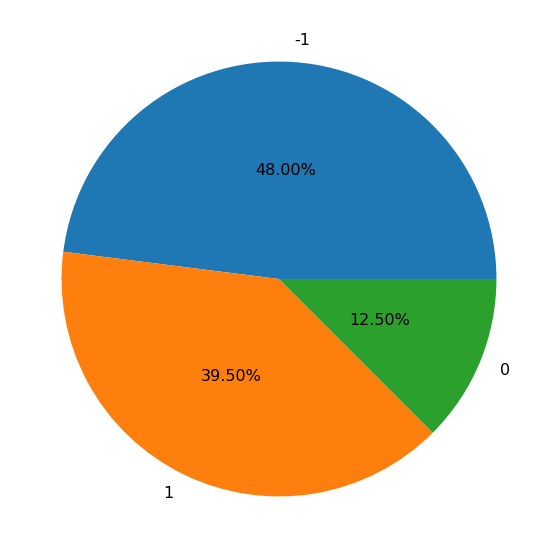

Samples processed: 209
BalancedAccuracy: 49.29%
WeightedF1: 57.31%
CohenKappa: 28.31%


Samples processed: 209
BalancedAccuracy: 42.60%
WeightedF1: 50.56%
CohenKappa: 17.64%


Samples processed: 209
BalancedAccuracy: 43.62%
WeightedF1: 53.24%
CohenKappa: 22.12%


7/7 [==============================] - 0s 2ms/step
Samples processed: 209
BalancedAccuracy: 95.14%
WeightedF1: 95.71%
CohenKappa: 92.87%
---------------------------------------------------------------


Samples processed: 219
BalancedAccuracy: 50.47%
WeightedF1: 60.01%
CohenKappa: 34.22%


Samples processed: 219
BalancedAccuracy: 45.42%
WeightedF1: 53.55%
CohenKappa: 22.51%


Samples processed: 219
BalancedAccuracy: 45.88%
WeightedF1: 55.44%
CohenKappa: 27.14%


7/7 [==============================] - 0s 25ms/step
Samples processed: 219
BalancedAccuracy: 96.74%
WeightedF1: 97.72%
CohenKappa: 96.23%
---------------------------------------------------------------


Samples processed: 229
BalancedAccuracy: 65.76%
WeightedF1: 74.14%
CohenKappa: 57.22%


Samples processed: 229
BalancedAccuracy: 51.77%
WeightedF1: 59.93%
CohenKappa: 33.42%


Samples processed: 229
BalancedAccuracy: 47.61%
WeightedF1: 57.90%
CohenKappa: 31.60%


8/8 [==============================] - 0s 2ms/step
Samples processed: 229
BalancedAccuracy: 97.24%
WeightedF1: 97.43%
CohenKappa: 95.70%
---------------------------------------------------------------


Samples processed: 239
BalancedAccuracy: 49.33%
WeightedF1: 58.42%
CohenKappa: 30.83%


Samples processed: 239
BalancedAccuracy: 46.25%
WeightedF1: 54.52%
CohenKappa: 24.30%


Samples processed: 239
BalancedAccuracy: 34.86%
WeightedF1: 39.77%
CohenKappa: 2.28%


8/8 [==============================] - 0s 7ms/step
Samples processed: 239
BalancedAccuracy: 97.55%
WeightedF1: 96.69%
CohenKappa: 94.50%
---------------------------------------------------------------


Samples processed: 249
BalancedAccuracy: 52.53%
WeightedF1: 61.03%
CohenKappa: 35.63%


Samples processed: 249
BalancedAccuracy: 49.48%
WeightedF1: 56.93%
CohenKappa: 28.64%


Samples processed: 249
BalancedAccuracy: 36.22%
WeightedF1: 38.69%
CohenKappa: 6.95%


8/8 [==============================] - 0s 2ms/step
Samples processed: 249
BalancedAccuracy: 95.96%
WeightedF1: 97.18%
CohenKappa: 95.35%
---------------------------------------------------------------


Samples processed: 259
BalancedAccuracy: 51.20%
WeightedF1: 59.39%
CohenKappa: 33.13%


Samples processed: 259
BalancedAccuracy: 48.24%
WeightedF1: 56.07%
CohenKappa: 27.54%


Samples processed: 259
BalancedAccuracy: 42.35%
WeightedF1: 50.34%
CohenKappa: 21.01%


9/9 [==============================] - 0s 4ms/step
Samples processed: 259
BalancedAccuracy: 96.08%
WeightedF1: 97.30%
CohenKappa: 95.53%
---------------------------------------------------------------


Samples processed: 269
BalancedAccuracy: 51.28%
WeightedF1: 58.69%
CohenKappa: 31.86%


Samples processed: 269
BalancedAccuracy: 48.03%
WeightedF1: 54.21%
CohenKappa: 24.32%


Samples processed: 269
BalancedAccuracy: 43.60%
WeightedF1: 52.49%
CohenKappa: 23.93%


9/9 [==============================] - 0s 2ms/step
Samples processed: 269
BalancedAccuracy: 94.24%
WeightedF1: 94.44%
CohenKappa: 90.87%
---------------------------------------------------------------


Samples processed: 279
BalancedAccuracy: 54.07%
WeightedF1: 61.27%
CohenKappa: 36.81%


Samples processed: 279
BalancedAccuracy: 52.48%
WeightedF1: 60.67%
CohenKappa: 35.41%


Samples processed: 279
BalancedAccuracy: 42.65%
WeightedF1: 51.32%
CohenKappa: 21.56%


9/9 [==============================] - 0s 3ms/step
Samples processed: 279
BalancedAccuracy: 96.23%
WeightedF1: 97.14%
CohenKappa: 95.28%
---------------------------------------------------------------


Samples processed: 289
BalancedAccuracy: 53.82%
WeightedF1: 62.09%
CohenKappa: 37.33%


Samples processed: 289
BalancedAccuracy: 48.28%
WeightedF1: 56.23%
CohenKappa: 27.65%


Samples processed: 289
BalancedAccuracy: 44.99%
WeightedF1: 54.40%
CohenKappa: 26.58%


10/10 [==============================] - 0s 739us/step
Samples processed: 289
BalancedAccuracy: 96.15%
WeightedF1: 96.55%
CohenKappa: 94.30%
---------------------------------------------------------------


Samples processed: 299
BalancedAccuracy: 51.55%
WeightedF1: 57.17%
CohenKappa: 29.44%


Samples processed: 299
BalancedAccuracy: 50.36%
WeightedF1: 54.97%
CohenKappa: 26.39%


Samples processed: 299
BalancedAccuracy: 42.10%
WeightedF1: 49.87%
CohenKappa: 19.77%


10/10 [==============================] - 0s 3ms/step
Samples processed: 299
BalancedAccuracy: 96.56%
WeightedF1: 97.34%
CohenKappa: 95.64%
---------------------------------------------------------------


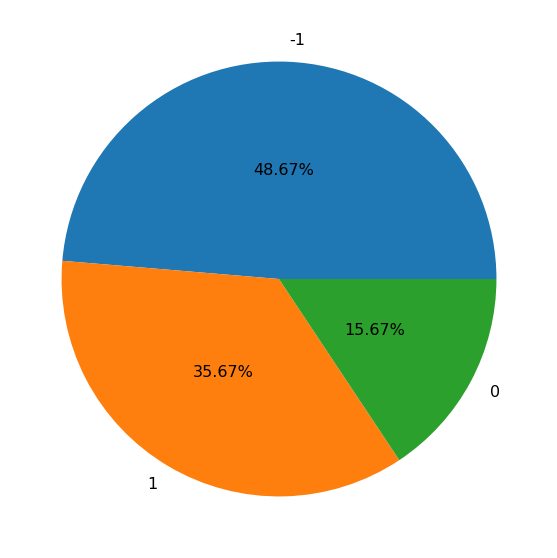

Samples processed: 309
BalancedAccuracy: 52.68%
WeightedF1: 59.47%
CohenKappa: 33.49%


Samples processed: 309
BalancedAccuracy: 44.82%
WeightedF1: 52.43%
CohenKappa: 21.94%


Samples processed: 309
BalancedAccuracy: 45.75%
WeightedF1: 54.38%
CohenKappa: 27.86%


10/10 [==============================] - 0s 3ms/step
Samples processed: 309
BalancedAccuracy: 96.00%
WeightedF1: 96.79%
CohenKappa: 94.74%
---------------------------------------------------------------


Samples processed: 319
BalancedAccuracy: 57.69%
WeightedF1: 64.37%
CohenKappa: 42.32%


Samples processed: 319
BalancedAccuracy: 49.84%
WeightedF1: 54.45%
CohenKappa: 25.86%


Samples processed: 319
BalancedAccuracy: 44.87%
WeightedF1: 52.24%
CohenKappa: 24.59%


10/10 [==============================] - 0s 3ms/step
Samples processed: 319
BalancedAccuracy: 96.42%
WeightedF1: 97.21%
CohenKappa: 95.45%
---------------------------------------------------------------


Samples processed: 329
BalancedAccuracy: 53.88%
WeightedF1: 60.53%
CohenKappa: 35.53%


Samples processed: 329
BalancedAccuracy: 47.58%
WeightedF1: 53.27%
CohenKappa: 23.95%


Samples processed: 329
BalancedAccuracy: 46.13%
WeightedF1: 53.39%
CohenKappa: 24.30%


11/11 [==============================] - 0s 2ms/step
Samples processed: 329
BalancedAccuracy: 95.48%
WeightedF1: 95.80%
CohenKappa: 93.15%
---------------------------------------------------------------


Samples processed: 339
BalancedAccuracy: 55.02%
WeightedF1: 61.71%
CohenKappa: 37.58%


Samples processed: 339
BalancedAccuracy: 47.47%
WeightedF1: 53.62%
CohenKappa: 24.49%


Samples processed: 339
BalancedAccuracy: 44.17%
WeightedF1: 51.43%
CohenKappa: 22.86%


11/11 [==============================] - 0s 2ms/step
Samples processed: 339
BalancedAccuracy: 96.57%
WeightedF1: 97.07%
CohenKappa: 95.21%
---------------------------------------------------------------


Samples processed: 349
BalancedAccuracy: 53.16%
WeightedF1: 59.58%
CohenKappa: 33.83%


Samples processed: 349
BalancedAccuracy: 54.61%
WeightedF1: 59.35%
CohenKappa: 33.58%


Samples processed: 349
BalancedAccuracy: 46.18%
WeightedF1: 54.80%
CohenKappa: 28.07%


11/11 [==============================] - 0s 2ms/step
Samples processed: 349
BalancedAccuracy: 97.97%
WeightedF1: 98.28%
CohenKappa: 97.20%
---------------------------------------------------------------


Samples processed: 359
BalancedAccuracy: 59.99%
WeightedF1: 65.68%
CohenKappa: 43.63%


Samples processed: 359
BalancedAccuracy: 50.31%
WeightedF1: 56.02%
CohenKappa: 27.69%


Samples processed: 359
BalancedAccuracy: 45.49%
WeightedF1: 53.55%
CohenKappa: 25.67%


12/12 [==============================] - 0s 2ms/step
Samples processed: 359
BalancedAccuracy: 98.33%
WeightedF1: 98.34%
CohenKappa: 97.28%
---------------------------------------------------------------


Samples processed: 369
BalancedAccuracy: 62.88%
WeightedF1: 69.49%
CohenKappa: 50.39%


Samples processed: 369
BalancedAccuracy: 52.10%
WeightedF1: 57.22%
CohenKappa: 29.57%


Samples processed: 369
BalancedAccuracy: 48.13%
WeightedF1: 55.97%
CohenKappa: 28.66%


12/12 [==============================] - 0s 2ms/step
Samples processed: 369
BalancedAccuracy: 96.79%
WeightedF1: 97.57%
CohenKappa: 96.03%
---------------------------------------------------------------


Samples processed: 379
BalancedAccuracy: 58.18%
WeightedF1: 64.59%
CohenKappa: 42.03%


Samples processed: 379
BalancedAccuracy: 53.47%
WeightedF1: 59.65%
CohenKappa: 33.96%


Samples processed: 379
BalancedAccuracy: 51.00%
WeightedF1: 59.08%
CohenKappa: 33.40%


12/12 [==============================] - 0s 2ms/step
Samples processed: 379
BalancedAccuracy: 97.70%
WeightedF1: 97.90%
CohenKappa: 96.56%
---------------------------------------------------------------


Samples processed: 389
BalancedAccuracy: 60.34%
WeightedF1: 65.78%
CohenKappa: 43.78%


Samples processed: 389
BalancedAccuracy: 53.76%
WeightedF1: 60.12%
CohenKappa: 34.62%


Samples processed: 389
BalancedAccuracy: 48.63%
WeightedF1: 56.43%
CohenKappa: 30.08%


13/13 [==============================] - 0s 2ms/step
Samples processed: 389
BalancedAccuracy: 98.89%
WeightedF1: 98.97%
CohenKappa: 98.32%
---------------------------------------------------------------


Samples processed: 399
BalancedAccuracy: 57.25%
WeightedF1: 64.39%
CohenKappa: 41.55%


Samples processed: 399
BalancedAccuracy: 48.42%
WeightedF1: 54.44%
CohenKappa: 25.38%


Samples processed: 399
BalancedAccuracy: 49.52%
WeightedF1: 56.83%
CohenKappa: 29.44%


13/13 [==============================] - 0s 2ms/step
Samples processed: 399
BalancedAccuracy: 97.84%
WeightedF1: 98.00%
CohenKappa: 96.73%
---------------------------------------------------------------


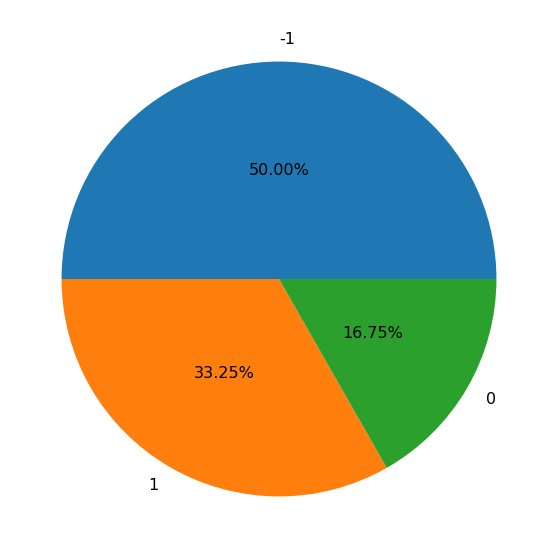

Samples processed: 409
BalancedAccuracy: 57.21%
WeightedF1: 63.60%
CohenKappa: 40.26%


Samples processed: 409
BalancedAccuracy: 48.19%
WeightedF1: 54.39%
CohenKappa: 25.58%


Samples processed: 409
BalancedAccuracy: 47.33%
WeightedF1: 54.68%
CohenKappa: 25.69%


13/13 [==============================] - 0s 2ms/step
Samples processed: 409
BalancedAccuracy: 98.70%
WeightedF1: 98.30%
CohenKappa: 97.23%
---------------------------------------------------------------


Samples processed: 419
BalancedAccuracy: 57.78%
WeightedF1: 63.22%
CohenKappa: 39.57%


Samples processed: 419
BalancedAccuracy: 51.75%
WeightedF1: 56.46%
CohenKappa: 28.30%


Samples processed: 419
BalancedAccuracy: 32.38%
WeightedF1: 36.92%
CohenKappa: -1.82%


14/14 [==============================] - 0s 2ms/step
Samples processed: 419
BalancedAccuracy: 98.89%
WeightedF1: 98.81%
CohenKappa: 98.06%
---------------------------------------------------------------


Samples processed: 429
BalancedAccuracy: 59.66%
WeightedF1: 65.56%
CohenKappa: 43.37%


Samples processed: 429
BalancedAccuracy: 51.63%
WeightedF1: 56.87%
CohenKappa: 29.10%


Samples processed: 429
BalancedAccuracy: 32.87%
WeightedF1: 32.97%
CohenKappa: -0.86%


14/14 [==============================] - 0s 2ms/step
Samples processed: 429
BalancedAccuracy: 97.67%
WeightedF1: 97.91%
CohenKappa: 96.57%
---------------------------------------------------------------


Samples processed: 439
BalancedAccuracy: 56.89%
WeightedF1: 63.42%
CohenKappa: 39.93%


Samples processed: 439
BalancedAccuracy: 49.36%
WeightedF1: 55.19%
CohenKappa: 26.75%


Samples processed: 439
BalancedAccuracy: 33.03%
WeightedF1: 32.98%
CohenKappa: -0.61%


14/14 [==============================] - 0s 2ms/step
Samples processed: 439
BalancedAccuracy: 97.35%
WeightedF1: 97.05%
CohenKappa: 95.17%
---------------------------------------------------------------


Samples processed: 449
BalancedAccuracy: 55.50%
WeightedF1: 61.95%
CohenKappa: 37.38%


Samples processed: 449
BalancedAccuracy: 45.86%
WeightedF1: 52.48%
CohenKappa: 21.91%


Samples processed: 449
BalancedAccuracy: 37.60%
WeightedF1: 43.30%
CohenKappa: 10.00%


15/15 [==============================] - 0s 1ms/step
Samples processed: 449
BalancedAccuracy: 97.93%
WeightedF1: 98.66%
CohenKappa: 97.81%
---------------------------------------------------------------


Samples processed: 459
BalancedAccuracy: 64.69%
WeightedF1: 68.75%
CohenKappa: 48.47%


Samples processed: 459
BalancedAccuracy: 48.52%
WeightedF1: 54.69%
CohenKappa: 25.21%


Samples processed: 459
BalancedAccuracy: 43.17%
WeightedF1: 51.49%
CohenKappa: 21.99%


15/15 [==============================] - 0s 2ms/step
Samples processed: 459
BalancedAccuracy: 98.47%
WeightedF1: 98.49%
CohenKappa: 97.51%
---------------------------------------------------------------


Samples processed: 469
BalancedAccuracy: 58.16%
WeightedF1: 64.14%
CohenKappa: 40.81%


Samples processed: 469
BalancedAccuracy: 47.09%
WeightedF1: 53.34%
CohenKappa: 23.35%


Samples processed: 469
BalancedAccuracy: 44.37%
WeightedF1: 52.18%
CohenKappa: 22.95%


15/15 [==============================] - 0s 2ms/step
Samples processed: 469
BalancedAccuracy: 97.51%
WeightedF1: 97.87%
CohenKappa: 96.51%
---------------------------------------------------------------


Samples processed: 479
BalancedAccuracy: 60.19%
WeightedF1: 65.57%
CohenKappa: 43.38%


Samples processed: 479
BalancedAccuracy: 50.95%
WeightedF1: 56.92%
CohenKappa: 29.60%


Samples processed: 479
BalancedAccuracy: 43.10%
WeightedF1: 50.43%
CohenKappa: 20.44%


15/15 [==============================] - 0s 3ms/step
Samples processed: 479
BalancedAccuracy: 96.91%
WeightedF1: 97.08%
CohenKappa: 95.25%
---------------------------------------------------------------


Samples processed: 489
BalancedAccuracy: 58.38%
WeightedF1: 63.61%
CohenKappa: 40.29%


Samples processed: 489
BalancedAccuracy: 52.35%
WeightedF1: 56.90%
CohenKappa: 29.49%


Samples processed: 489
BalancedAccuracy: 42.58%
WeightedF1: 49.73%
CohenKappa: 18.76%


16/16 [==============================] - 0s 2ms/step
Samples processed: 489
BalancedAccuracy: 96.15%
WeightedF1: 96.33%
CohenKappa: 94.02%
---------------------------------------------------------------


Samples processed: 499
BalancedAccuracy: 58.72%
WeightedF1: 64.09%
CohenKappa: 41.38%


Samples processed: 499
BalancedAccuracy: 51.98%
WeightedF1: 56.31%
CohenKappa: 28.94%


Samples processed: 499
BalancedAccuracy: 45.15%
WeightedF1: 51.64%
CohenKappa: 22.84%


16/16 [==============================] - 0s 2ms/step
Samples processed: 499
BalancedAccuracy: 97.62%
WeightedF1: 97.60%
CohenKappa: 96.11%
---------------------------------------------------------------


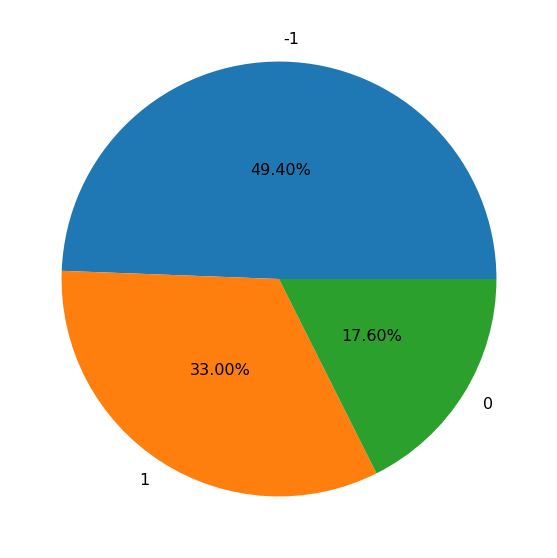

Samples processed: 509
BalancedAccuracy: 59.59%
WeightedF1: 64.37%
CohenKappa: 41.54%


Samples processed: 509
BalancedAccuracy: 52.88%
WeightedF1: 58.47%
CohenKappa: 32.25%


Samples processed: 509
BalancedAccuracy: 46.00%
WeightedF1: 53.16%
CohenKappa: 25.19%


16/16 [==============================] - 0s 4ms/step
Samples processed: 509
BalancedAccuracy: 97.73%
WeightedF1: 97.65%
CohenKappa: 96.18%
---------------------------------------------------------------


Samples processed: 519
BalancedAccuracy: 61.44%
WeightedF1: 66.31%
CohenKappa: 44.87%


Samples processed: 519
BalancedAccuracy: 52.72%
WeightedF1: 57.34%
CohenKappa: 30.16%


Samples processed: 519
BalancedAccuracy: 43.99%
WeightedF1: 50.53%
CohenKappa: 20.64%


17/17 [==============================] - 0s 2ms/step
Samples processed: 519
BalancedAccuracy: 97.87%
WeightedF1: 98.08%
CohenKappa: 96.88%
---------------------------------------------------------------


Samples processed: 529
BalancedAccuracy: 60.23%
WeightedF1: 64.87%
CohenKappa: 42.53%


Samples processed: 529
BalancedAccuracy: 58.16%
WeightedF1: 63.03%
CohenKappa: 39.84%


Samples processed: 529
BalancedAccuracy: 49.13%
WeightedF1: 56.22%
CohenKappa: 29.77%


17/17 [==============================] - 0s 3ms/step
Samples processed: 529
BalancedAccuracy: 98.27%
WeightedF1: 98.30%
CohenKappa: 97.24%
---------------------------------------------------------------


Samples processed: 539
BalancedAccuracy: 57.99%
WeightedF1: 63.78%
CohenKappa: 40.73%


Samples processed: 539
BalancedAccuracy: 54.67%
WeightedF1: 59.37%
CohenKappa: 33.62%


Samples processed: 539
BalancedAccuracy: 47.99%
WeightedF1: 53.56%
CohenKappa: 25.23%


17/17 [==============================] - 0s 3ms/step
Samples processed: 539
BalancedAccuracy: 98.18%
WeightedF1: 98.70%
CohenKappa: 97.88%
---------------------------------------------------------------


Samples processed: 549
BalancedAccuracy: 59.23%
WeightedF1: 64.54%
CohenKappa: 41.95%


Samples processed: 549
BalancedAccuracy: 54.86%
WeightedF1: 60.06%
CohenKappa: 34.65%


Samples processed: 549
BalancedAccuracy: 50.59%
WeightedF1: 57.27%
CohenKappa: 31.29%


18/18 [==============================] - 0s 2ms/step
Samples processed: 549
BalancedAccuracy: 97.89%
WeightedF1: 98.00%
CohenKappa: 96.75%
---------------------------------------------------------------


Samples processed: 559
BalancedAccuracy: 55.51%
WeightedF1: 61.57%
CohenKappa: 37.10%


Samples processed: 559
BalancedAccuracy: 51.73%
WeightedF1: 57.11%
CohenKappa: 30.07%


Samples processed: 559
BalancedAccuracy: 34.59%
WeightedF1: 40.64%
CohenKappa: 2.33%


18/18 [==============================] - 0s 2ms/step
Samples processed: 559
BalancedAccuracy: 97.88%
WeightedF1: 98.21%
CohenKappa: 97.08%
---------------------------------------------------------------


Samples processed: 569
BalancedAccuracy: 58.15%
WeightedF1: 63.27%
CohenKappa: 39.78%


Samples processed: 569
BalancedAccuracy: 51.00%
WeightedF1: 57.08%
CohenKappa: 30.02%


Samples processed: 569
BalancedAccuracy: 33.45%
WeightedF1: 34.11%
CohenKappa: 0.28%


18/18 [==============================] - 0s 2ms/step
Samples processed: 569
BalancedAccuracy: 98.26%
WeightedF1: 98.25%
CohenKappa: 97.14%
---------------------------------------------------------------


Samples processed: 579
BalancedAccuracy: 64.44%
WeightedF1: 68.72%
CohenKappa: 48.70%


Samples processed: 579
BalancedAccuracy: 54.72%
WeightedF1: 59.50%
CohenKappa: 33.81%


Samples processed: 579
BalancedAccuracy: 33.95%
WeightedF1: 36.22%
CohenKappa: 1.46%


19/19 [==============================] - 0s 2ms/step
Samples processed: 579
BalancedAccuracy: 98.18%
WeightedF1: 98.28%
CohenKappa: 97.19%
---------------------------------------------------------------


Samples processed: 589
BalancedAccuracy: 57.68%
WeightedF1: 63.08%
CohenKappa: 39.25%


Samples processed: 589
BalancedAccuracy: 47.45%
WeightedF1: 53.67%
CohenKappa: 24.28%


Samples processed: 589
BalancedAccuracy: 37.12%
WeightedF1: 42.16%
CohenKappa: 8.48%


19/19 [==============================] - 1s 8ms/step
Samples processed: 589
BalancedAccuracy: 98.36%
WeightedF1: 98.15%
CohenKappa: 96.98%
---------------------------------------------------------------


Samples processed: 599
BalancedAccuracy: 61.27%
WeightedF1: 67.25%
CohenKappa: 46.25%


Samples processed: 599
BalancedAccuracy: 52.09%
WeightedF1: 56.90%
CohenKappa: 29.60%


Samples processed: 599
BalancedAccuracy: 35.96%
WeightedF1: 41.40%
CohenKappa: 6.60%


19/19 [==============================] - 1s 5ms/step
Samples processed: 599
BalancedAccuracy: 97.92%
WeightedF1: 98.33%
CohenKappa: 97.29%
---------------------------------------------------------------


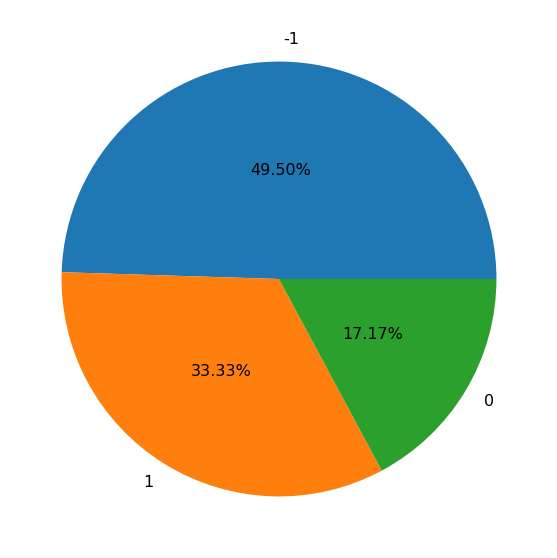

Samples processed: 609
BalancedAccuracy: 62.56%
WeightedF1: 67.98%
CohenKappa: 47.44%


Samples processed: 609
BalancedAccuracy: 53.74%
WeightedF1: 58.42%
CohenKappa: 31.81%


Samples processed: 609
BalancedAccuracy: 38.54%
WeightedF1: 45.20%
CohenKappa: 12.09%


20/20 [==============================] - 0s 6ms/step
Samples processed: 609
BalancedAccuracy: 98.80%
WeightedF1: 98.85%
CohenKappa: 98.13%
---------------------------------------------------------------


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001AA0AEA81F0>
Traceback (most recent call last):
  File "C:\Users\selma\anaconda3\lib\weakref.py", line 371, in remove
KeyboardInterrupt: 


KeyboardInterrupt: 

In [6]:
X=[]
Y=[]
final_results_knn = []
final_results_logreg = []
final_results_HT = []
final_results_logreg_embedd = []
for message in consumer:
    msg= message.value['text']
    X.append(msg)
    #print(msg)
    y= message.value['label']
    #print(y)
    Y.append(y)
    if len(X)%10==0:
        X_train_counts = count_vect.fit_transform(X)
        X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts).todense()
        
        #Training a knn model with tfidf:
        display(HTML("<h3>kNN results</h3>"))
        knn_results = evaluate(stream=iter_pandas(pd.DataFrame(X_train_tfidf), pd.Series(Y)),model=knn)
        final_results_knn.append(knn_results)
        
        #Training a one versus one, logistic regression model with tfidf:
        display(HTML("<h3>one_vs_one logistic regression results</h3>"))
        logReg_one_vs_one_results = evaluate(stream=iter_pandas(pd.DataFrame(X_train_tfidf), pd.Series(Y)),model=log_regr_one_vs_one)
        final_results_logreg.append(logReg_one_vs_one_results)
        
        #Training a hoeffding tree classifier model with tfidf:
        display(HTML("<h3>Hoeff tree results</h3>"))
        Hoef_tree_results = evaluate(stream=iter_pandas(pd.DataFrame(X_train_tfidf), pd.Series(Y)),model=Hoef_tree)
        final_results_HT.append(Hoef_tree_results)
        
        #Training a one versus one, logistic regression model with embeddings vector:
        display(HTML("<h3>one_vs_one logistic regression results With embeddings</h3>"))
        X_em = [one_hot(d, vocab_size) for d in X]
        X_em = pad_sequences(X_em, maxlen=max_length, padding='pre')
        X_embeddings = model.predict(X_em)
        logReg_one_vs_one_results = evaluate(stream=iter_pandas(pd.DataFrame(X_embeddings), pd.Series(Y)),model=log_regr_one_vs_one)
        final_results_logreg_embedd.append(logReg_one_vs_one_results)
        print("---------------------------------------------------------------")
        
    if len(X)%100==0:
        pie, ax = plt.subplots(figsize=[15,10])
        plt.pie(x = pd.Series(Y).value_counts(), autopct='%.2f%%', labels=list(pd.Series(Y).unique().astype('str')), pctdistance=0.5, textprops={'fontsize': 16})
        plt.show()

In [8]:
final_results_logreg1 = np.array([np.array(final_results_logreg[i][0]) for i in range(len(final_results_logreg))])
final_results_HT1 = np.array([np.array(final_results_HT[i][0]) for i in range(len(final_results_HT))])
final_results_logreg_embedd1 = np.array([np.array(final_results_logreg_embedd[i][0]) for i in range(len(final_results_logreg_embedd))])
final_results_knn1 = np.array([np.array(final_results_knn[i][0]) for i in range(len(final_results_knn))])

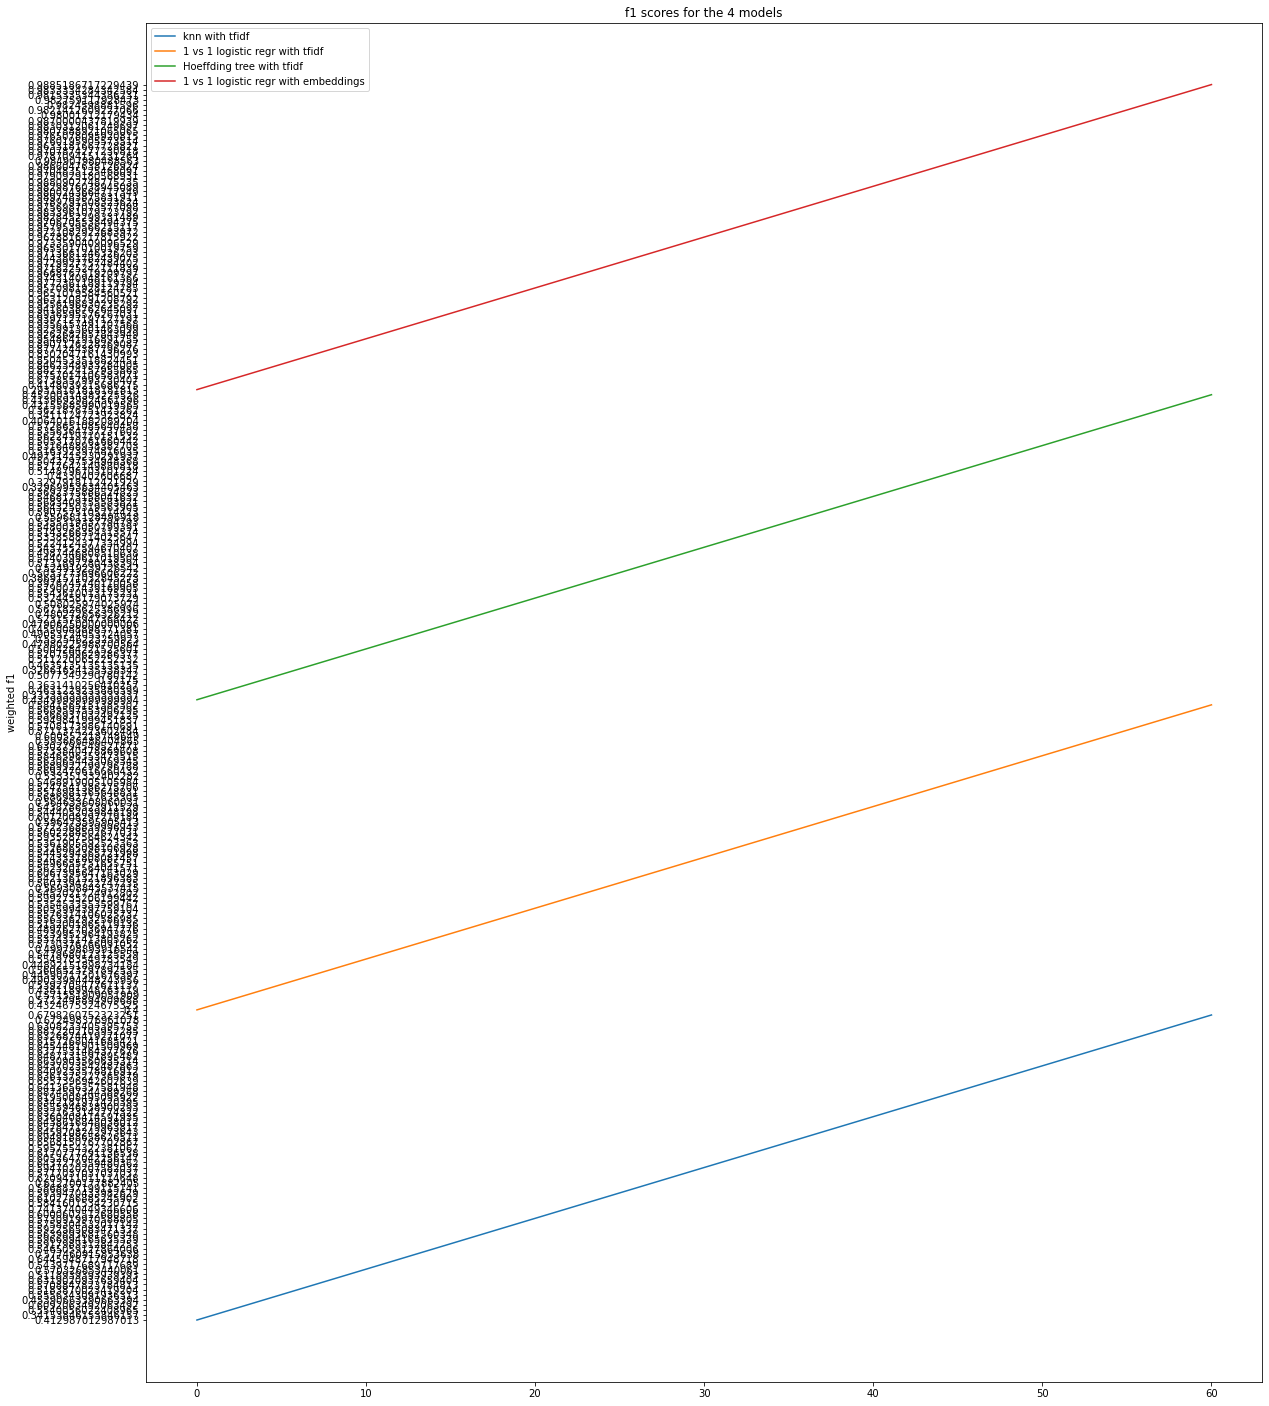

In [27]:
#printing the evolution of weighted f1 for the 4 cases:
plt.figure(figsize=(20,25))
plt.title("f1 scores for the 4 models")
plt.plot(final_results_knn1[:,4], label='knn with tfidf')
plt.plot(final_results_logreg1[:,4], label='1 vs 1 logistic regr with tfidf')
plt.plot(final_results_HT1[:,4], label='Hoeffding tree with tfidf')
plt.plot(final_results_logreg_embedd1[:,4], label='1 vs 1 logistic regr with embeddings')
plt.legend()
plt.ylabel("weighted f1")
plt.show()

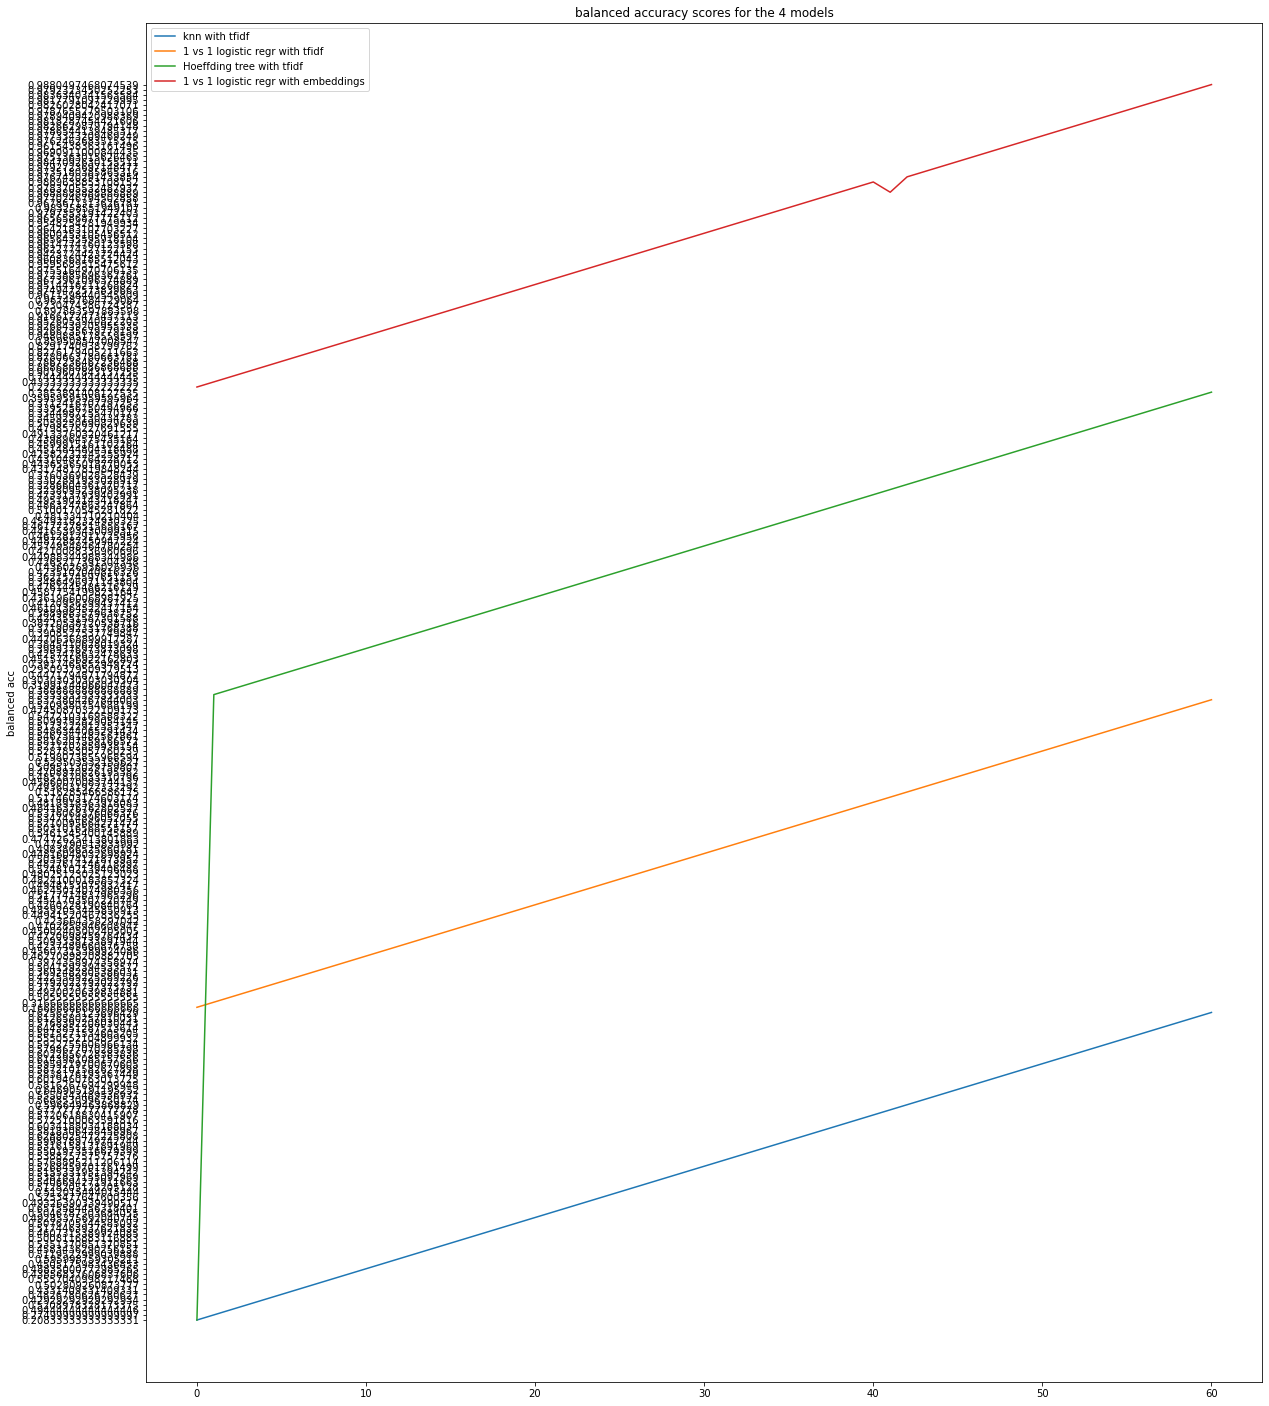

In [25]:
#printing the evolution of balanced accuracy for the 4 cases:
plt.figure(figsize=(20,25))
plt.title("balanced accuracy scores for the 4 models")
plt.plot(final_results_knn1[:,2], label='knn with tfidf')
plt.plot(final_results_logreg1[:,2], label='1 vs 1 logistic regr with tfidf')
plt.plot(final_results_HT1[:,2], label='Hoeffding tree with tfidf')
plt.plot(final_results_logreg_embedd1[:,2], label='1 vs 1 logistic regr with embeddings')
plt.legend()
plt.ylabel("balanced acc")
plt.show()

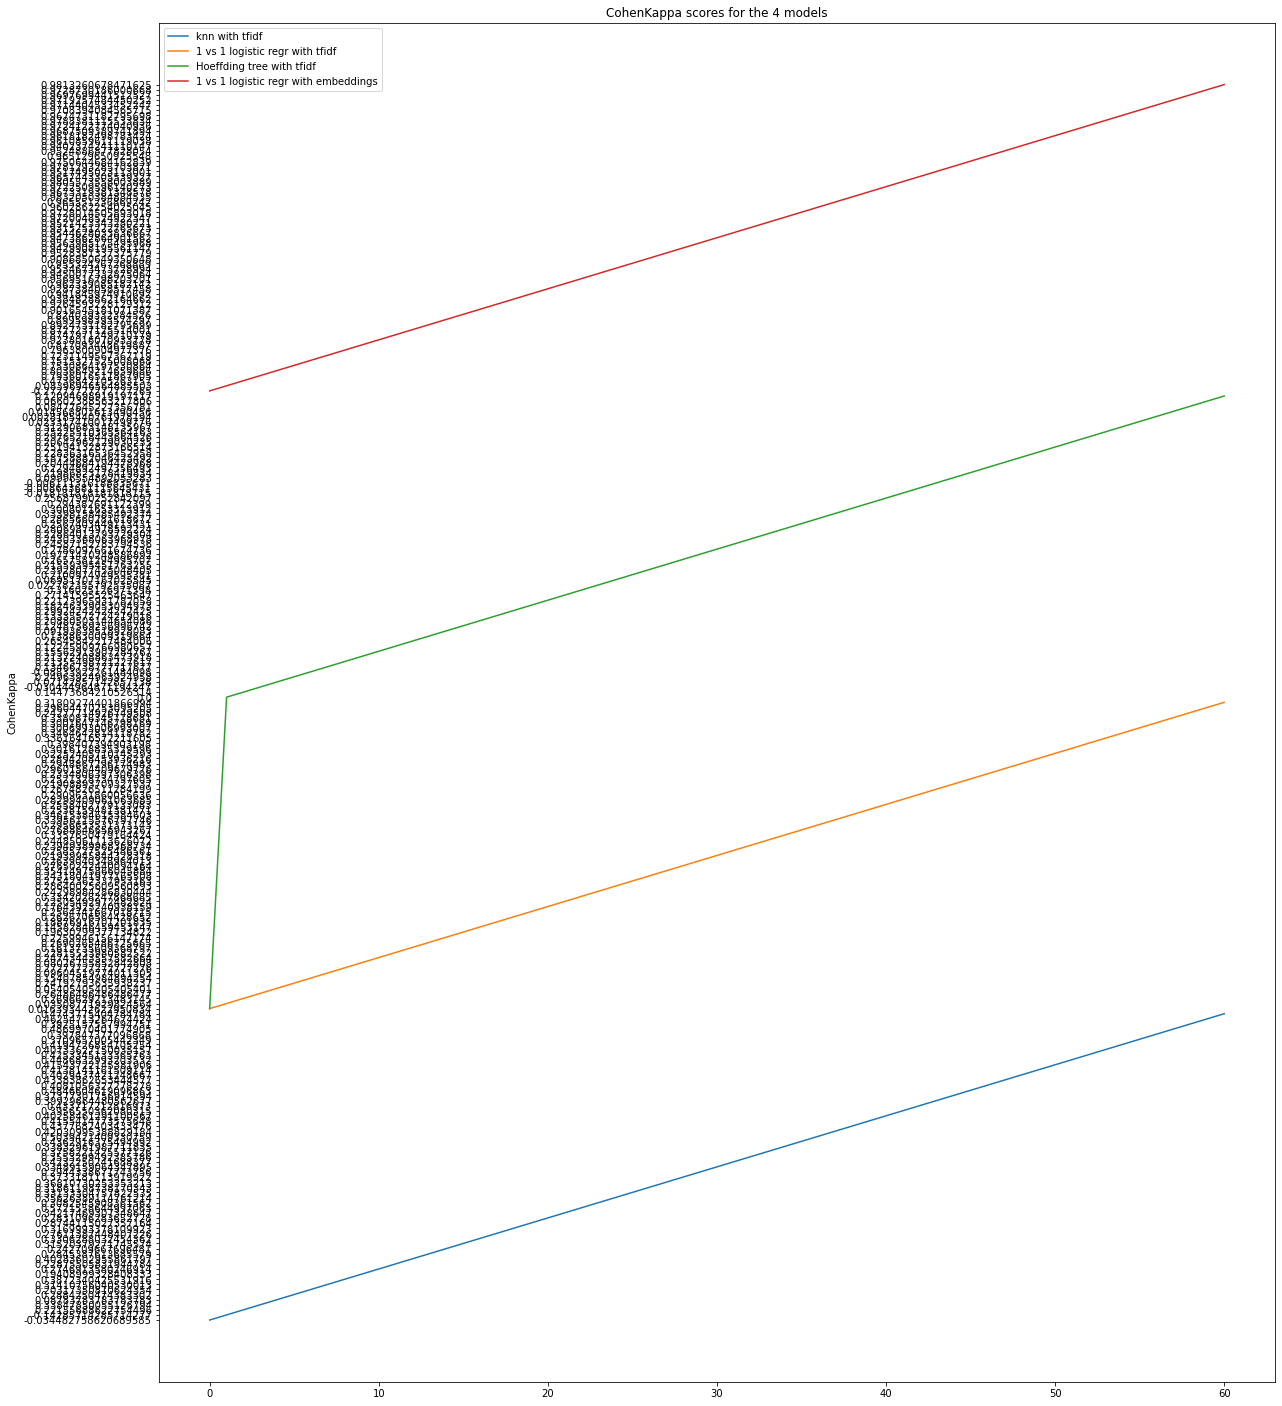

In [26]:
#printing the evolution of CohenKappa for the 4 cases:
plt.figure(figsize=(20,25))
plt.title("CohenKappa scores for the 4 models")
plt.plot(final_results_knn1[:,6], label='knn with tfidf')
plt.plot(final_results_logreg1[:,6], label='1 vs 1 logistic regr with tfidf')
plt.plot(final_results_HT1[:,6], label='Hoeffding tree with tfidf')
plt.plot(final_results_logreg_embedd1[:,6], label='1 vs 1 logistic regr with embeddings')
plt.legend()
plt.ylabel("CohenKappa")
plt.show()